In [90]:
import psycopg2 as pg2
import pandas as pd
from datetime import datetime
import BuildModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import BuildModel
import importlib
from matplotlib import pyplot as plt

In [91]:
print ("Connecting to SQL")
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')

print ("Reading Dataset")
df = pd.read_sql ("""Select *  from auction_full where auctiontime >= '2020-01-01'""", conn)

print ("Splitting into Train/Test Sets")
df = df.sort_values("auctiontime")

Connecting to SQL
Reading Dataset
Splitting into Train/Test Sets


In [92]:
X = df
y = df['is_winner']

In [93]:
df

,auctionid,is_winner,cardtype,cashvalue,cardvalue,fee,bidvalue,limited_allowed,is_locked,auctiontime,...,bom_streak3,perc_to_bin3,prev_is_new_user3,prev_auction_count3,prev_overbid3,prev_giveup_one3,prev_give_before_six3,prev_wins3,prev_bids3,prev_bom_bids3
30824,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.013793,0.0,78.0,0.000000,0.346154,0.756410,0.000000,4.179487,0.333333
30747,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
30746,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
30745,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
30744,391464514,False,Shell,58,50,1.99,20,False,False,2020-01-01 00:00:05,...,0.0,0.006897,0.0,647.0,0.006182,0.375580,0.646059,0.041731,12.040185,7.302937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244981,466450592,False,None,6,0,0.00,15,False,True,2020-02-29 15:14:24,...,8.0,0.533333,0.0,207.0,0.169082,0.115942,0.236715,0.275362,50.144928,41.473430
4244982,466450592,False,None,6,0,0.00,15,False,True,2020-02-29 15:14:24,...,8.0,0.533333,0.0,207.0,0.169082,0.115942,0.236715,0.275362,50.144928,41.473430
4244983,466450592,False,None,6,0,0.00,15,False,True,2020-02-29 15:14:24,...,8.0,0.533333,0.0,207.0,0.169082,0.115942,0.236715,0.275362,50.144928,41.473430
4244974,466450592,False,None,6,0,0.00,15,False,True,2020-02-29 15:14:24,...,0.0,0.066667,0.0,15.0,0.066667,0.266667,0.800000,0.000000,22.000000,12.400000


In [94]:
train_cut_off  = datetime(2020, 2, 15) 
test_cut_off = datetime(2020, 3, 1)


X_train = X[X.auctiontime <= train_cut_off]
y_train = y[X.auctiontime <= train_cut_off]

X_test = X[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]
y_test = y[(X.auctiontime > train_cut_off)&(X.auctiontime <= test_cut_off)]

X_holdout = X[X.auctiontime > test_cut_off]
y_holdout = y[X.auctiontime > test_cut_off]



In [226]:
importlib.reload(BuildModel)
print ("Fitting Model")
def create_model():
    # Define a Keras model
    model = Sequential()

    # Add a Dense layer that uses the sigmoid function
    model.add(Dense(units=30, kernel_initializer='random_uniform',
                bias_initializer='zeros', activation='relu', input_dim=74))
    model.add(Dense(units=30, kernel_initializer='random_uniform',
                bias_initializer='zeros',  activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

clf = KerasClassifier(build_fn=create_model,epochs=17,batch_size=100,validation_split=.1)

model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
model = clf

pm = BuildModel.PennyModel(model, is_regressor=False,sampling_ratio=.2 )

pm.fit(X_train, y_train)

Fitting Model
4. Fitting model
Train on 93403 samples, validate on 10379 samples
Epoch 1/17
93403/93403 [==============================] - 2s 25us/step - loss: 0.2448 - accuracy: 0.9245 - val_loss: 2.7306 - val_accuracy: 0.0000e+00
Epoch 2/17
93403/93403 [==============================] - 2s 23us/step - loss: 0.2316 - accuracy: 0.9257 - val_loss: 2.6568 - val_accuracy: 0.0000e+00
Epoch 3/17
93403/93403 [==============================] - 2s 23us/step - loss: 0.2291 - accuracy: 0.9259 - val_loss: 2.7466 - val_accuracy: 0.0000e+00
Epoch 4/17
93403/93403 [==============================] - 2s 23us/step - loss: 0.2269 - accuracy: 0.9259 - val_loss: 2.5896 - val_accuracy: 0.0000e+00
Epoch 5/17
93403/93403 [==============================] - 2s 23us/step - loss: 0.2254 - accuracy: 0.9259 - val_loss: 2.6941 - val_accuracy: 0.0000e+00
Epoch 6/17
93403/93403 [==============================] - 2s 23us/step - loss: 0.2240 - accuracy: 0.9259 - val_loss: 2.1492 - val_accuracy: 0.0053
Epoch 7/17
93403/

In [219]:
def get_actual_and_potential_profits(Xin, yin):
    potential_profits =  (Xin.cashvalue - Xin.fee - Xin.bid/100) -.4
    actual_profits = yin * (Xin.cashvalue - Xin.fee - Xin.bid/100) -.4
    return potential_profits, actual_profits

In [220]:
cprobs = pm.predict_proba_calibrated(X_test)[:,1]

In [221]:
pp, ap = get_actual_and_potential_profits(X_test,y_test)

In [222]:
cprobs

array([0.01152416, 0.00140605, 0.01105522, ..., 0.02505695, 0.01125461,
       0.04706015], dtype=float32)

In [223]:
expected_value = np.multiply(cprobs, pp) -  (1-cprobs)*.4

In [224]:
sum(ap[expected_value>0])

28503.829999962425

In [190]:

#self.train_pop/self.sampling_ratio + self.target_pop
#        self.sampled_target_pop = self.target_pop


(3337283, 17297)

In [97]:
import math
def get_profit(l, u, probs, potential_profits, actual_profits):
    print ("trying",l,u)
    maxprof = -math.inf
    maxp = 0
    for p in np.arange(0, 1, .01):
        profit = sum(actual_profits[(probs > p)&(potential_profits >= l)&(potential_profits < u)])
 #       print (p, profit)
        if (profit > maxprof):
          #  total_bets = sum(probs > p)
            maxp = p
            maxprof = profit
    return (l, u, maxp), maxprof, sum(probs > maxp)

In [98]:
def get_profit_buckets(Xin, yin):
    print ("getting probabilities")
    probs = pm.predict_proba(Xin)[:,1]
    print ("getting profits")
    potential_profits, actual_profits =  get_actual_and_potential_profits(Xin, yin)

    print ("getting buckets")
    #potential_profits, actual_profits = get_potential_and_acutal_profits(X_test, y_test)
    buckets = []
    buckets.append(get_profit(0, 5.7, probs, potential_profits, actual_profits))
    buckets.append(get_profit(5.7, 9.7, probs, potential_profits, actual_profits))
    buckets.append(get_profit(9.7, 19.7, probs, potential_profits, actual_profits))
    buckets.append(get_profit(19.7, 40, probs, potential_profits, actual_profits))
    buckets.append(get_profit(40, 62,probs, potential_profits, actual_profits))
    buckets.append(get_profit(62,100, probs, potential_profits, actual_profits))
    buckets.append(get_profit(100,200, probs, potential_profits, actual_profits))
    return buckets

In [99]:
buckets = get_profit_buckets(X_test, y_test)

getting probabilities
2. Transforming data
getting profits
getting buckets
trying 0 5.7
trying 5.7 9.7
trying 9.7 19.7
trying 19.7 40
trying 40 62
trying 62 100
trying 100 200


In [100]:
profit_sum = 0
bets_sum = 0
for b in buckets:
    bets_sum += b[2]
    profit_sum += b[1]
print(bets_sum, profit_sum, profit_sum/bets_sum)

842770 32718.94000001899 0.038823095269194426


In [101]:
pm.pickle(filename="rf.pkl")

5. Pickling model as penny_auction.pickle


In [104]:
probs = pm.predict_proba(X_test)[:,1]

2. Transforming data


In [108]:
calibration = calibration (probs, X_train.shape[0], sum(X_train.is_winner),  sum(X_train.is_winner)*2, sum(X_train.is_winner))

In [134]:
pp, ap = get_actual_and_potential_profits(X_test, y_test)
pp = np.array(pp)

In [161]:
sum(expected_value[expected_value > 0])

31476.382150766545

2. Transforming data


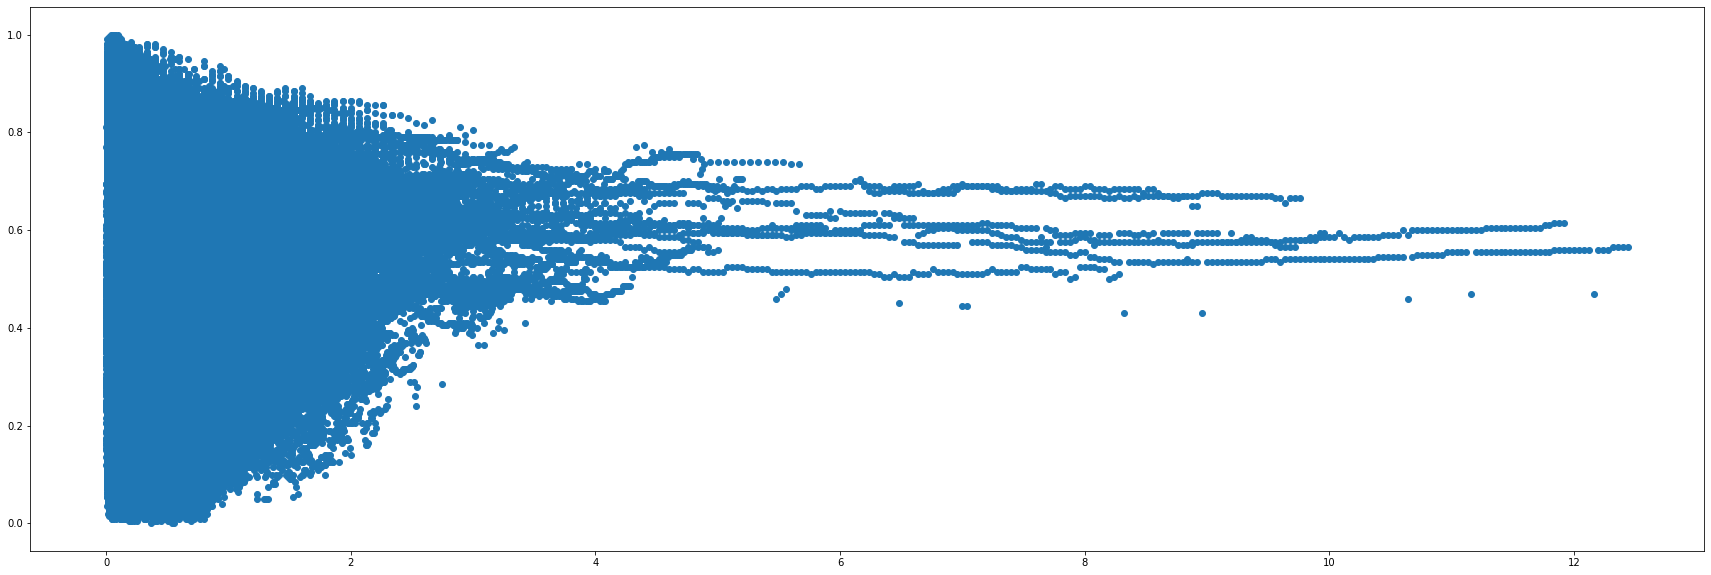

In [89]:
f = "perc_to_bin0"
amazon_50_30 = X_test  #[(X_test.cardtype=="Amazon")&(X_test.bidvalue==100)&(X_test.cardvalue==0)]
test_df = amazon_50_30.sort_values(f)
preds = pm.predict_proba(test_df)[:,1]
preds
fig, ax = plt.subplots(figsize=(30, 10))
ax.scatter(test_df[f], preds)

# Random Forest:   26,480/25,802

In [90]:
def evaluate_holdout(Xin, yin):
    holdout_probs = pm.predict_proba(Xin)[:,1]
    holdout_potential_profits, holdout_actual_profits = get_actual_and_potential_profits(Xin, yin)
    total_profit = 0
    for b in buckets:
     #   print(b)
        l = b[0][0]
        u = b[0][1]
        thresh =  b[0][2]
        mask = (holdout_potential_profits > l)&(holdout_potential_profits < u)&(holdout_probs > thresh)
        print (sum(holdout_actual_profits[mask]))
     #   print(X_holdout.cardtype[mask&y_holdout].value_counts())
        total_profit += sum(holdout_actual_profits[mask])
       # total_bets =  sum(b[2])
        print(sum((holdout_potential_profits > l)&(holdout_potential_profits < u)), sum(mask))
        print("****************")
    print (total_profit)   

In [91]:
evaluate_holdout(X_holdout, y_holdout)

2. Transforming data
-12.889999999999981
12677 167
****************
116.55000000000005
31997 1063
****************
796.9400000000511
64775 2711
****************
10233.650000004822
241665 25121
****************
8841.890000006097
277041 31694
****************
3729.1299999994367
87788 11464
****************
222.17000000000255
25397 360
****************
23927.44000001041


In [83]:
buckets

[((0, 5.7, 0.98),
  17.000000000000195,
  array([False, False, False, ..., False, False, False])),
 ((5.7, 9.7, 0.9),
  133.39999999999512,
  array([False, False, False, ..., False, False, False])),
 ((9.7, 19.7, 0.78),
  1085.3100000000218,
  array([False, False, False, ..., False, False, False])),
 ((19.7, 40, 0.66),
  16661.16000000705,
  array([ True, False,  True, ..., False,  True, False])),
 ((40, 62, 0.52),
  17653.790000007873,
  array([ True, False,  True, ...,  True,  True, False])),
 ((62, 100, 0.48),
  4531.390000000543,
  array([ True, False,  True, ...,  True,  True,  True])),
 ((100, 200, 0.5700000000000001),
  577.9500000000024,
  array([ True, False,  True, ..., False,  True, False]))]